In [11]:
from math import *
import numpy as np
from matplotlib import pyplot as plt

### Zu Satz 5.8: Fehler der Polynominterpolation 

Bei äquidistanten Stützstellen ist die Fehlerfunktion 

$\omega(x) = \prod_{k=0}^n (x-x_k)$

an den Rändern des Intervalls sehr viel größer als in der Mitte.

Durch geschickte (nicht-äquidistante) Wahl der Stützstellen erhält man einen gleichmäßigeren Verlauf der Fehlerkurve (z.B. Tschebyscheff-Interpolation, Numerik 2).

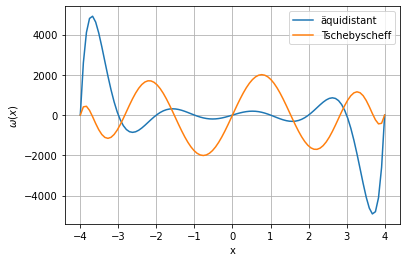

In [12]:
x1 = [k for k in range(-4,5)] #äquidistante Stützstellen
x2 = [4*cos((k-4)*pi/8.) for k in range(-4,5)] #Tschebyscheff-Stützstellen
x = np.linspace(-4,4,100)
omega1 = 1
for k in range(-4,5):
    omega1 *= (x - x1[k])
omega2 = 1
for k in range(-4,5):
    omega2 *= (x - x2[k])
plt.plot(x, omega1, label='äquidistant')
plt.plot(x, omega2, label='Tschebyscheff')
plt.grid()
plt.xlabel('x')
plt.ylabel(r'$\omega(x)$')
plt.legend()
plt.show()

### Beispiel: Interpolation des Logarithmus

Aus den Werten von $\ln(x)$ für $x\in\{1.4, 1.5, 1.6, 1.7\}$ soll $\ln(1.57)$ genähert werden.

Wir bestimmen drei Interpolationspolynome:<br>
$P_1$ mit den Stützstellen $1.5, 1.6$,<br>
$P_2$ mit den Stützstellen $1.4, 1.5, 1.6$,<br> 
$P_3$ mit den Stützstellen $1.4, 1.5, 1.6, 1.7$,<br>
und werten sie an der Stelle $x=1.57$ mit dem Horner-Schema aus.

Aus notebook07.ipynb übernommen:

In [13]:
def horner(x, xs, c):
    """Berechnet den Wert des Interpolationspolynoms P_n an der Stelle x 
    für die Stützstellen xs und die Koeffizienten der Newton-Darstellung c."""
    n = len(c) - 1
    if len(xs) < n:
        raise Exception("Zu wenige Stützstellen!")
    p = c[n]
    for k in range(n-1, -1, -1):
        p = c[k] + (x - xs[k])*p
    return p 

In [14]:
def newton_coeffs(xs, ys):
    """Berechnet die Koeffizienten c des Interpolationspolynoms in 
    Newton-Darstellung für die Stützstellen xs und Werte ys."""
    n = len(xs) - 1
    if not len(ys) == n+1:
        raise Exception("""Brauche genauso viele Stützstellen wie Werte!""")
    c = 1.*ys
    for k in range(1, n+1):
        for i in range(n, k-1, -1):
            c[i] = (c[i] - c[i-1])/(xs[i] - xs[i-k])
    return c

In [15]:
xs = np.linspace(1.4, 1.7, 4)
ys = np.log(xs)
x = 1.57
y = log(x)
print('exakt: y = {:.10f}'. format(y))
c1 = newton_coeffs(xs[1:3], ys[1:3])
y1 = horner(x, xs[1:3], c1)
print('P1:    y = {:.10f}, Fehler: {:8.1e}'.format(y1, y1 - y))
c2 = newton_coeffs(xs[0:3], ys[0:3])
y2 = horner(x, xs[0:3], c2)
print('P2:    y = {:.10f}, Fehler: {:8.1e}'.format(y2, y2 - y))
c3 = newton_coeffs(xs, ys)
y3 = horner(x, xs, c3)
print('P3:    y = {:.10f}, Fehler: {:8.1e}'.format(y3, y3 - y))

exakt: y = 0.4510756194
P1:    y = 0.4506420729, Fehler: -4.3e-04
P2:    y = 0.4511097797, Fehler:  3.4e-05
P3:    y = 0.4510776229, Fehler:  2.0e-06


### Hermite-Interpolation

Wir wollen die Funktion

$ f(x) = e^x \sin(5x), \quad f'(x) = e^x(\sin(5x) + 5 \cos(5x))$

im Intervall $[0,1]$ nach Hermite interpolieren.
Wir verwenden nur $n+1=2$ Stützstellen, also nur die Intervallgrenzen, wo wir die Funktionswerte und ersten Ableitungen vorgeben.

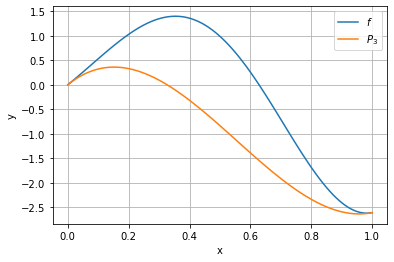

In [16]:
def f(x):
    return np.exp(x)*np.sin(5*x)

def f1(x):  #f'(x)
    return np.exp(x)*(np.sin(5*x) + 5*np.cos(5*x))

#Notation dividierte Differenzen: Di = [yi], Dij = [yi, yj], Dijk = [yi, yj, yk], Dijkl = [yi, yj, yk, yl]

x0 = 0
x1 = 1

D0 = f(x0)
D1 = f(x1)
c0 = D0

D00 = f1(x0)
D01 = (D1 - D0)/(x1 - x0)
D11 = f1(x1)
c1 = D00

D001 = (D01 - D00)/(x1 - x0)
D011 = (D11 - D01)/(x1 - x0)
c2 = D001

D0011 = (D011 - D001)/(x1 - x0)
c3 = D0011

#Auswertung des Interpolationspolynoms mit Horner-Schema
xs = [x0, x0, x1, x1]  #doppelte Stützstellen!
c = [c0, c1, c2, c3]
x = np.linspace(0, 1, 100)
P = horner(x, xs, c)

plt.plot(x, f(x), label=r'$f$')
plt.plot(x, P, label=r'$P_3$')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

**Beachte**: an den Stützstellen $x_0=0$, $x_1=1$ stimmen nicht nur die Funktionswerte mit der Interpolation überein, sondern auch die Ableitungen. 

## 5.2 Spline-Interpolation
Aus Kapitel 3 brauchen wir:

In [17]:
def thomas(a, b, c, d):
    """Löst das tridiagonale lineare Gleichungssystem mit Hauptdiagonale a, rechter Nebendiagonale b, linker Nebendiagonale c und rechter Seite d. Eingabeargumente alles Zeilenvektoren."""
    n = len(d) - 1  #Indizes 0,1,...,n
    l = np.zeros(n)     #Nebendiagonale von L
    m = np.zeros(n+1)   #Hauptdiagonale von U
    y = np.zeros(n+1)   #Zwischenlösung
    x = np.zeros(n+1)   #Lösung
    #LU-Zerlegung
    m[0] = a[0]
    for i in range(n):
        l[i] = c[i+1]/m[i]
        m[i+1] = a[i+1] - l[i]*b[i]
    #Vorwärtssubstitution Ly = d
    y[0] = d[0]
    for i in range(1,n+1):
        y[i] = d[i] - l[i-1]*y[i-1]
    #Rückwärtssubstitution Ux = y
    x[n] = y[n]/m[n]
    for i in range(n-1,-1,-1):
        x[i] = (y[i] - b[i]*x[i+1])/m[i]
    return x

In [18]:
def cubic_spline_coeffs(xs, ys):
    """Berechnet aus den Stützstellen xs und Stützstellen ys die Koeffizienten a, b, c des kubischen Splines mit natürlichen Randbedingungen."""
    n = len(xs) - 1
    if not len(ys) == n+1:
        raise Exception("xs und ys müssen gleiche Länge haben")
    h = xs[1:n+1] - xs[0:n]
    #Koeffizienten des tridiagonalen LGS
    alpha = np.zeros(n+1)
    beta = np.zeros(n+1)
    gamma = np.zeros(n+1)
    delta = np.zeros(n+1)
    gamma[1:n] = h[0:n-1]/6.
    alpha[1:n] = (h[0:n-1] + h[1:n])/3.
    beta[1:n] = h[1:n]/6.
    delta[1:n] = (ys[2:n+1] - ys[1:n])/h[1:n] - (ys[1:n] - ys[0:n-1])/h[0:n-1]
    #natürliche Randbedingungen
    alpha[0] = 1
    alpha[n] = 1
    #Löse tridiagonales LGS mit Thomas-Algorithmus
    c = thomas(alpha, beta, gamma, delta)
    #Setze übrige Koeffizienten
    a = ys[0:n] - h[0:n]**2*c[0:n]/6. 
    b = (ys[1:n+1] - ys[0:n])/h[0:n] - h[0:n]*(c[1:n+1] - c[0:n])/6. 
    return a, b, c  

In [19]:
def evaluate_cubic_spline(x, xs, a, b, c):
    """Wertet den kubischen Spline mit den Stützstellen xs und Koeffizienten a, b, c auf x aus."""
    n = len(xs) - 1
    if not (len(a)==n and len(b)==n and len(c)==n+1):
        raise Exception("Koeffizientenvektoren haben nicht die passende Länge")
    h = xs[1:n+1] - xs[0:n]
    s = np.zeros_like(x)
    for i in range(n):
        #konstruiere logischen Vektor Ii für das Teilintervall [xs[i], xs[i+1]]
        if i==n-1:            
            Ii = np.logical_and(x >= xs[i], x <= xs[i+1])
        else:
            Ii = np.logical_and(x >= xs[i], x < xs[i+1])
        x_ = x[Ii]  #der Teil von x im Intervall [xs[i], xs[i+1]]
        #Spline-Ansatz
        si = a[i] + b[i]*(x_ - xs[i]) + (c[i]*(xs[i+1] - x_)**3 + c[i+1]*(x_ - xs[i])**3)/(6*h[i])
        s[Ii] = si
    return s

### Beispiel

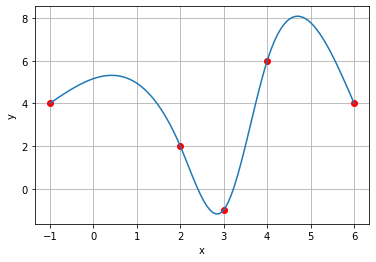

In [20]:
xs = np.array([-1, 2, 3, 4, 6])
ys = np.array([4, 2, -1, 6, 4])
a, b, c = cubic_spline_coeffs(xs, ys)
x = np.linspace(-1, 6, 100)
y = evaluate_cubic_spline(x, xs, a, b, c)
plt.plot(xs, ys, 'ro')
plt.plot(x, y)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()